In [ ]:
import duckdb
import json
from datetime import date, timedelta
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

In [ ]:
with open("credentials.json") as f:
    d = json.load(f)

pg = d["postgres"]
aws = d["aws"]
bucket = "s3://carlos-s3-bdet-ducklake" 

def secreto(con):
    print("Iniciando")
    #con = duckdb.connect( )
    con.sql("INSTALL ducklake; LOAD ducklake;")
    con.sql("INSTALL spatial; LOAD spatial;")
    con.sql("INSTALL httpfs; LOAD httpfs;")
    con.sql("INSTALL postgres; LOAD postgres;")

    print("Librerias cargadas")

    con.sql(f"""
        CREATE OR REPLACE SECRET secreto_s3 (
        TYPE s3,
        KEY_ID '{aws["login"]}',
        SECRET '{aws["password"]}',
        REGION 'eu-central-1'
    )
    """)

    print("Secreto s3 creado")

    con.sql(f"""
        CREATE OR REPLACE SECRET secreto_postgres (
        TYPE postgres,
        HOST '{pg["host"]}',
        PORT {pg["port"]},
        DATABASE '{pg["schema"]}',
        USER '{pg["login"]}',
        PASSWORD '{pg["password"]}'
        )
    """)

    print("Secreto postgres creado")

    con.sql("""
        CREATE OR REPLACE SECRET secreto_ducklake (
            TYPE ducklake,
            METADATA_PATH '',
            METADATA_PARAMETERS MAP {'TYPE': 'postgres', 'SECRET': 'secreto_postgres'}
        );
        """)
    
    print("secreto ducklake creado")

    con.sql(f"""
        ATTACH 'ducklake:secreto_ducklake' AS mobility_ducklake (DATA_PATH '{bucket}', OVERRIDE_DATA_PATH TRUE) """)
    con.sql("""
        USE mobility_ducklake """)
    
    print("fin")

In [17]:
con = duckdb.connect()
secreto(con)

Iniciando
Librerias cargadas
Secreto s3 creado
Secreto postgres creado
secreto ducklake creado
fin


In [20]:
query = """--sql
    SELECT 
        g.origin_id,
        -- Calculamos el gap promedio ponderado o simple. 
        -- Aquí uso promedio simple del ratio, pero podrías hacer SUM(gap)/SUM(potential)
        AVG(g.gap_ratio) as avg_gap_ratio,
        
        -- Convertimos la geometría a TEXTO (WKT) para que Pandas la entienda fácil
        ST_AsText(s.geometria) as geom_wkt
    FROM gold_infrastructure_gaps g
    JOIN silver_geometries s 
        ON g.origin_id = s.distrito_id
    GROUP BY g.origin_id, s.geometria
"""

df = con.sql(query)

In [25]:
df

,origin_id,avg_gap_ratio,geom_wkt,geometry
0,0203706,189.635861,"POLYGON ((623314.4606999997 4241151.455499999,...","POLYGON ((623314.4606999997 4241151.455499999,..."
1,0207403,45.796849,"POLYGON ((620657.7226999998 4282265.1185, 6215...","POLYGON ((620657.7226999998 4282265.1185, 6215..."
2,0206601,142.704350,"POLYGON ((653204.0832000002 4335108.7631, 6529...","POLYGON ((653204.0832000002 4335108.7631, 6529..."
3,0204001,106.396200,"POLYGON ((631641.9537000004 4307818.9923, 6314...","POLYGON ((631641.9537000004 4307818.9923, 6314..."
4,0206101,94.264967,"POLYGON ((631366.8081999999 4268066.901799999,...","POLYGON ((631366.8081999999 4268066.901799999,..."
5,0200701,45.330959,"POLYGON ((653204.0832000002 4335108.7631, 6529...","POLYGON ((653204.0832000002 4335108.7631, 6529..."
6,0202301,87.900915,"POLYGON ((653204.0832000002 4335108.7631, 6529...","POLYGON ((653204.0832000002 4335108.7631, 6529..."
7,0204101,91.846487,"POLYGON ((653204.0832000002 4335108.7631, 6529...","POLYGON ((653204.0832000002 4335108.7631, 6529..."
8,0205101,62.811454,"POLYGON ((631366.8081999999 4268066.901799999,...","POLYGON ((631366.8081999999 4268066.901799999,..."
9,0202701,181.959079,"POLYGON ((631366.8081999999 4268066.901799999,...","POLYGON ((631366.8081999999 4268066.901799999,..."


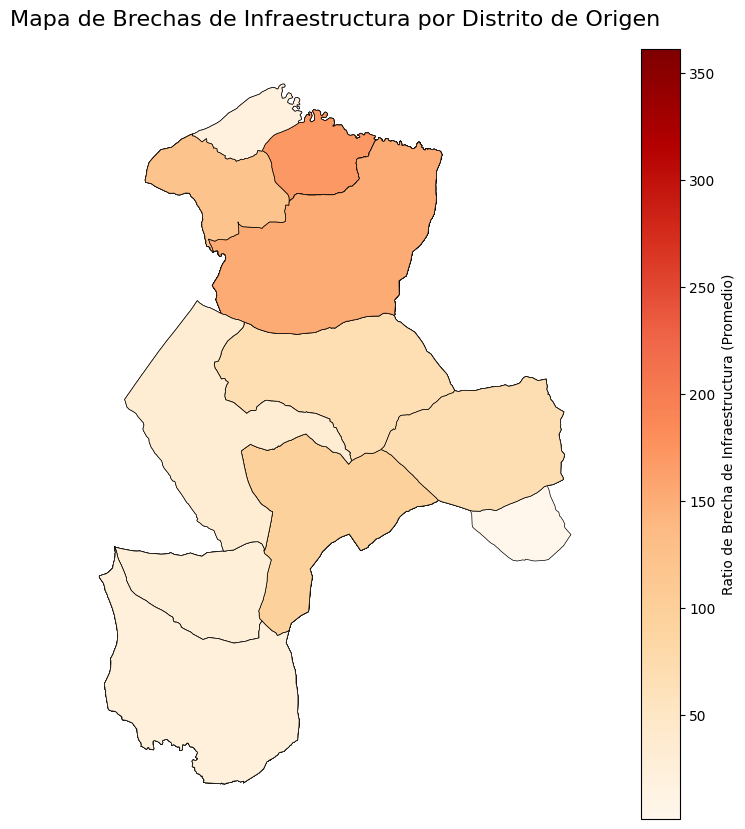

In [23]:
# 3. Ejecutar y obtener DataFrame
df = con.sql(query).df()

# 4. Convertir a GeoDataFrame
# Transformamos la columna de texto WKT a objetos geométricos reales
df['geometry'] = df['geom_wkt'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 5. Definir el sistema de coordenadas (CRS)
# Como tus datos son del MITMA/España, seguramente son ETRS89 UTM 30N (EPSG:25830)
gdf.set_crs("EPSG:25830", inplace=True)

# --- VISUALIZACIÓN ---

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 10))

# Pintar el mapa
gdf.plot(
    column='avg_gap_ratio', # La columna que define el color
    cmap='OrRd',            # Mapa de color (Rojos para indicar "alerta/gap")
    legend=True,            # Mostrar barra de leyenda
    legend_kwds={'label': "Ratio de Brecha de Infraestructura (Promedio)"},
    edgecolor='black',      # Bordes de los distritos
    linewidth=0.5,
    ax=ax
)

# Añadir título y limpiar ejes
plt.title('Mapa de Brechas de Infraestructura por Distrito de Origen', fontsize=16)
plt.axis('off') # Quitar ejes X/Y para que quede limpio

# Mostrar
plt.show()

In [16]:
date_start = '2023-05-08'
date_end = '2023-05-08'
year = 2023

query = f"""--sql
                    CREATE OR REPLACE TABLE gold_gravity_features AS

                    WITH trips AS (
                        -- Agregación masiva inicial
                        SELECT 
                            origin_id, 
                            destination_id, 
                            SUM(travels) as actual_trips
                        FROM silver_trips_filtrado
                        WHERE date BETWEEN '{date_start}' AND '{date_end}'
                        ORDER BY origin_id, destination_id
                        GROUP BY 1, 2
                    )

                    SELECT 
                        t.origin_id,
                        t.destination_id,
                        t.actual_trips,
                        
                        -- Distancia segura (min 500m)
                        GREATEST(d.distance_meters, 500.0) as dist_meters,
                        
                        -- Variables del modelo (Casteamos a DOUBLE para evitar overflow en multiplicaciones)
                        CAST(pop.poblacion AS DOUBLE) as P_i,
                        CAST(econ.renta_total_euros AS DOUBLE) as E_j,
                        
                        -- Gravedad Cruda pre-calculada: (P * E) / d^2
                        (CAST(pop.poblacion AS DOUBLE) * CAST(econ.renta_total_euros AS DOUBLE)) 
                            / POWER(GREATEST(d.distance_meters, 500.0), 2) as gravity_raw

                    FROM trips t

                    -- JOINs con las tablas Silver
                    JOIN silver_distances d 
                        ON t.origin_id = d.origin_id 
                        AND t.destination_id = d.destination_id

                    JOIN silver_demographics pop 
                        ON t.origin_id = pop.distrito_id 
                        AND pop.year = {year}

                    JOIN silver_demographics econ 
                        ON t.destination_id = econ.distrito_id 
                        AND econ.year = {year};"""

In [ ]:
con.sql()

In [8]:
polygon = 'POLYGON((40.9 -1.7, 40.9 0.9, 37.8 0.9, 37.8 -1.7, 40.9 -1.7))'
date_start = '2023-05-08'
date_end = '2023-05-08'

query = f"""--sql
                CREATE OR REPLACE TABLE silver_trips_filtrado AS
                WITH zona_estudio AS (
                    SELECT distrito_id
                    FROM silver_geometries
                    WHERE ST_Within(
                        centroide, 
                        ST_Transform(
                            ST_GeomFromText('{polygon}'),
                            'EPSG:4326', 
                            'EPSG:25830'
                        )
                    )
                )
                SELECT 
                    t.date,
                    t.period,
                    t.origin_id,
                    t.destination_id,
                    t.travels
                FROM silver_trips t
                INNER JOIN zona_estudio origen ON t.origin_id = origen.distrito_id
                INNER JOIN zona_estudio destino ON t.destination_id = destino.distrito_id
                WHERE 
                    t.date BETWEEN '{date_start}' AND '{date_end}';"""

con.sql(query)

In [14]:
con.sql("SELECT * FROM silver_trips_filtrado LIMIT 10")

┌──────┬────────┬───────────┬────────────────┬─────────┐
│ date │ period │ origin_id │ destination_id │ travels │
│ date │ int32  │  varchar  │    varchar     │ double  │
├──────┴────────┴───────────┴────────────────┴─────────┤
│                        0 rows                        │
└──────────────────────────────────────────────────────┘

In [5]:
poligono = 'POLYGON((40.9 -1.7, 40.9 0.9, 37.8 0.9, 37.8 -1.7, 40.9 -1.7))'

con.sql(f"""--sql
        SELECT 
            distrito_id
        FROM silver_geometries
        WHERE ST_Within(
            centroide, 
            ST_Transform(
                    ST_GeomFromText('{poligono}'),
                'EPSG:4326', 
                'EPSG:25830'
            )
        );""")

┌─────────────┐
│ distrito_id │
│   varchar   │
├─────────────┤
│ 0200501     │
│ 0200701     │
│ 0202301     │
│ 0202902     │
│ 0203706     │
│ 0205601     │
│ 0207403     │
│ 0207404     │
│ 0207902     │
│ 0208301     │
│    ·        │
│    ·        │
│    ·        │
│ 4622701     │
│ 4623504     │
│ 4623601     │
│ 4623901     │
│ 4624801     │
│ 4624902     │
│ 4625003     │
│ 4626201     │
│ 4690401     │
│ NA          │
├─────────────┤
│  1092 rows  │
│ (20 shown)  │
└─────────────┘

In [23]:
con.sql(f"""--sql
        SELECT 
            distrito_id,
            centroide
        FROM silver_geometries
        WHERE ST_Within(
            centroide, 
            ST_GeomFromText('POLYGON((500000.0 4760000.0, 500000.0 4764000.0, 502400.0 4764000, 502400.0 4760000, 500000.0 4760000.0))')
        );""")

┌─────────────┬──────────────────────────────────────────────┐
│ distrito_id │                  centroide                   │
│   varchar   │                   geometry                   │
├─────────────┼──────────────────────────────────────────────┤
│ 0100201     │ POINT (502306.66342558316 4763642.870954381) │
└─────────────┴──────────────────────────────────────────────┘

In [28]:
con.sql("SELECT distrito_id, centroide FROM silver_geometries WHERE distrito_id = '2418801' LIMIT 10")

┌─────────────┬──────────────────────────────────────────────┐
│ distrito_id │                  centroide                   │
│   varchar   │                   geometry                   │
├─────────────┼──────────────────────────────────────────────┤
│ 2418801     │ POINT (293794.36424201383 4684252.104875557) │
└─────────────┴──────────────────────────────────────────────┘

In [29]:
con.sql("SELECT * FROM bronze_distritos_nombres WHERE ID = '24188' LIMIT 10")

┌─────────┬──────────────────────┐
│   ID    │         name         │
│ varchar │       varchar        │
├─────────┼──────────────────────┤
│ 24188   │ Valencia de Don Juan │
└─────────┴──────────────────────┘